In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from IPython.display import display
import GPy

In [4]:
np.random.seed(123) # Initialize random number generator

## Motivation
A Gaussian process is fully specified by a mean function $m(x)$ and a covariance function $k(x,x')$:

\begin{equation}
f(x) \sim \mathcal{GP}\big(m(x),k(x,x')\big)
\end{equation}

Compare this to some common parametric models:
 - Logistic regression: $y = \sigma(\mathbf{\theta}^T\mathbf{x})$
 - Bayesian linear regression: $y \sim \mathcal{N}(\mathbf{\theta}^T\mathbf{x},\sigma^2)$
 
These models assume that the data generating process follows some parametric form. On the other hand, the "parameters" of a Gaussian process are the functions itself. Without loss of generality, the mean function is usually set to zero, $m(x) = 0$. Whereas, the covariance function or kernel simply defines how any two data points should covary.

## A distribution over functions
Because of its non-parametric form, the prior of a Gaussian process is a *distribution over functions*. This property is something worth understanding because it is the reason for the expressiveness and generalisation ability of GPs.

First, we can define a GP prior by selecting a mean function, which we will set to zero, and a covariance function. In this case, we will use the squared exponential kernel:

\begin{equation}
k(x,x') = \sigma^2 \text{exp}\Big(\frac{-(x-x')^2}{2l^2}\Big)
\end{equation}

We will consider two hyperparameters of the kernel:
 - The scale factor $\sigma^2$ determines the average distance of the function away from its mean.
 - The length scale $l$ determines the radius of influence that every point $x$ has on its neighbouring points $x'$.

Training a GP requires us to tune the kernel hyperparameters by optimising a likelihood measure. But for now, let's define our kernel with $\sigma^2 = 0.5^2$ and $l = 1$.

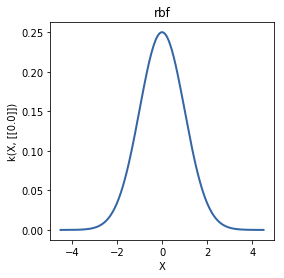

In [19]:
k = GPy.kern.RBF(1, variance=0.5**2, lengthscale=1)
figure, ax = plt.subplots(1,1, figsize=(4,4))
k.plot(ax=ax, x=0)
ax.set_title(k.name.replace('_', ' '))
plt.show()

## Sampling functions from a GP prior
With a prior in place, we have effectively specified a distribution over functions. In other words, our choice of kernel determines that some functions are more likely than others. For instance:
 - Using the squared exponential kernel, we expect the function to be smooth.
 - With $l = 1$, we expect strong covariance between points which are within one unit length of each other.
 - With $\sigma^2 = 0.5^2$, we expect the function to not stray too far from the predicted mean.

We can visualise what this might look like by drawing samples from our distribution. In particular, we will randomly sample function values at a finite set of $x$ values, and plot them on a graph. 

In [4]:
# Graph parameters
lb = -5
ub = 5
y_min = -3
y_max = 3

In [5]:
def initFirstPoint():
    firstPoint = True
    x_new = 0
    mu_new = 0 
    s_new = 1
    return firstPoint, x_new, mu_new, s_new

In [6]:
def initData():
    X_train = np.array([])
    y_train = np.array([])
    
    n_test = 100
    X_test = np.linspace(lb,ub,n_test)
    mu_test = np.zeros((n_test,1))
    s_test = np.ones((n_test,1))
    return X_train, y_train, X_test.reshape(-1,1), mu_test, s_test

# Initialise GP kernel

In [7]:
def initRegressionModel(X_train,y_train,k):
    m = GPy.models.GPRegression(X_train, y_train, k, noise_var=0)
    return m

In [8]:
def addTrainingPoint(X_train,y_train,x_new,y_new):    
    X_train = np.append(X_train,x_new)
    y_train = np.append(y_train,y_new)
    return X_train.reshape(-1,1), y_train.reshape(-1,1)

In [9]:
def addConfidenceBounds(ax,x,mu,s):
    ax.fill_between(np.squeeze(x), np.squeeze(mu-2*s), np.squeeze(mu+2*s), facecolor='grey', alpha=0.2)

def removeConfidenceBounds(ax):
    for coll in (ax.collections): ax.collections.remove(coll)

In [10]:
# Code to create animation
import matplotlib.animation
plt.rcParams["animation.html"] = "html5"

# Reset data
firstPoint, x_new, mu_new, s_new = initFirstPoint()
X_train, y_train, X_test, mu_test, s_test = initData()

# Initialise plot
fig,ax = plt.subplots(1,1, figsize=(8, 6), dpi=100)
ax.set_xlim(lb,ub)
ax.set_ylim(y_min,y_max)
plt.title('Sampling from GP kernel')
plt.ylabel('y'); plt.xlabel('x');

line_post, = ax.plot(X_test,mu_test)
line_next = ax.axvline(x_new,y_min,y_max,color='r', linestyle="dashed")
pts_train, = ax.plot(X_train,y_train,'rx', label="training points")
addConfidenceBounds(ax,X_test,mu_test,s_test)

def addAndRetrain(b=None):
    global X_train,y_train,mu_test,s_test,x_new,mu_new,s_new,firstPoint,m
    # Add new training point based on x_new
    y_new = np.random.normal(mu_new, s_new)
    X_train,y_train = addTrainingPoint(X_train,y_train,x_new,y_new) 
    if firstPoint:
        firstPoint = False
        m = initRegressionModel(X_train,y_train,k)   
    
    # Update training data
    m.set_XY(X_train,y_train)
    
    # Generate predictions
    mu_test, s2_test = m.predict(X_test)
    s_test = np.sqrt(s2_test)

    # Sample next training point
    x_new = np.random.uniform(low=lb, high=ub, size=1) 
    mu_new, s2_new = m.predict(x_new.reshape(-1,1))
    s_new = np.sqrt(s2_new)
    
    updatePlot()
    
def resetPlot(b=None):
    global X_train,y_train,mu_test,s_test,x_new,mu_new,s_new,firstPoint,m
    firstPoint, x_new, mu_new, s_new = initFirstPoint()
    X_train, y_train, X_test, mu_test, s_test = initData()
    updatePlot()
    
def updatePlot():
    line_post.set_data(X_test,mu_test)
    pts_train.set_data(X_train,y_train)
    line_next.set_xdata(x_new)
    removeConfidenceBounds(ax)
    addConfidenceBounds(ax,X_test,mu_test,s_test)    
    fig.canvas.draw()

def animate(i):
    if i == 0: resetPlot()
    else: addAndRetrain()

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=10, interval = 1000)

In [11]:
ani